# Model Evaluation

In [24]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import os

class ImprovedLSTM(nn.Module):
    def __init__(self):
        super(ImprovedLSTM, self).__init__()
        
        self.hidden_size = 256
        self.num_layers = 3
        self.input_size = 10
        
        # LSTM
        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,
            bidirectional=True
        )
        
        # Layer Normalization for LSTM output
        self.layer_norm_lstm = nn.LayerNorm(2 * self.hidden_size)  # Bidirectional LSTM output size
        
        # Fully connected layers
        self.fc1 = nn.Linear(2 * self.hidden_size, 256)
        self.layer_norm_fc1 = nn.LayerNorm(256)  # LayerNorm for fc1
        
        self.fc2 = nn.Linear(256, 128)
        self.layer_norm_fc2 = nn.LayerNorm(128)  # LayerNorm for fc2
        
        self.fc3 = nn.Linear(128, 64)
        self.layer_norm_fc3 = nn.LayerNorm(64)  # LayerNorm for fc3
        
        self.fc4 = nn.Linear(64, 1)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Pass through LSTM
        lstm_output, _ = self.lstm(x)  # lstm_output: (batch_size, seq_length, 2 * hidden_size)
        
        # Take the output of the last time step
        lstm_output = lstm_output[:, -1, :]  # (batch_size, 2 * hidden_size)
        
        # Apply Layer Normalization to LSTM output
        lstm_output = self.layer_norm_lstm(lstm_output)
        
        # Fully connected layers with Layer Normalization, activation, and dropout
        x = self.fc1(lstm_output)
        x = self.layer_norm_fc1(x)  # LayerNorm for fc1
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.layer_norm_fc2(x)  # LayerNorm for fc2
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.layer_norm_fc3(x)  # LayerNorm for fc3
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        
        # Output layer
        out = self.sigmoid(x)  # Assuming binary classification or scaled output
        
        return out

In [33]:
#dias = "Dias 1 a 13"
dias = "Dia 14"

#recurso = "CPU"
#recurso = "RAM"
recurso = "Rede"

# Configuração de caminhos
model_path = "models/model_best_rmse.pt"

if recurso == "CPU":
    if dias == "Dias 1 a 13":
        data_path = "Server_1_Training_Sets/datasets/cpu_usage_1-13.xlsx"
    elif dias == "Dia 14":
        data_path = "Server_1_Training_Sets/datasets/cpu_usage_14.xlsx"
        
elif recurso == "RAM":
    if dias == "Dias 1 a 13":
        data_path = "Server_1_Training_Sets/datasets/ram_usage_1-13.xlsx"
    elif dias == "Dia 14":
        data_path = "Server_1_Training_Sets/datasets/ram_usage_14.xlsx"

elif recurso == "Rede":
    if dias == "Dias 1 a 13":
        data_path = "Server_1_Training_Sets/datasets/network_usage_1-13.xlsx"
    elif dias == "Dia 14":
        data_path = "Server_1_Training_Sets/datasets/network_usage_14.xlsx"
        
# Verificar dispositivo disponível (CPU ou GPU)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

# Carregar o modelo treinado
model = torch.load(model_path)
model = model.to(device)  # Mover modelo para o dispositivo apropriado
model.eval()  # Configura o modelo para modo de avaliação

# Carregar os dados do dia 14
#df = pd.read_excel(data_path_14)
df = pd.read_excel(data_path)
X_test = df.iloc[:, :-1].values  # Todas as colunas, exceto a última (entradas)
y_test = df.iloc[:, -1].values   # Apenas a última coluna (saídas reais)

# Ajustar o formato de X_test para compatibilidade com a LSTM
# Adicionar dimensão seq_length=1, ficando no formato (batch_size, seq_length, input_size)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).to(device)  # (batch_size, 1, 40)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Fazer previsões
predictions = []

with torch.no_grad():
    y_pred = model(X_test_tensor)  # Entrada já está no formato adequado (batch_size, 1, 40)

# Converter tensores para numpy (movendo para CPU antes de converter)
y_pred = y_pred.squeeze().cpu().numpy()
y_test = y_test_tensor.cpu().numpy()

# Calcular o RMSE
rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))

# Imprimir os resultados
print(f"RMSE no Conjunto de Teste ({dias}): {rmse:.6f}")
print(f"Total de Amostras de Teste: {len(X_test)}")

# Salvar resultados em um arquivo
os.makedirs("models", exist_ok=True)
with open("models/performance.txt", "a") as f:
    f.write(f"\nModel Test RMSE ({dias}): {rmse:.6f}")

Using device: cpu


/tmp/ipykernel_40813/147662052.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


RMSE no Conjunto de Teste (Dia 14): 0.007222
Total de Amostras de Teste: 1428


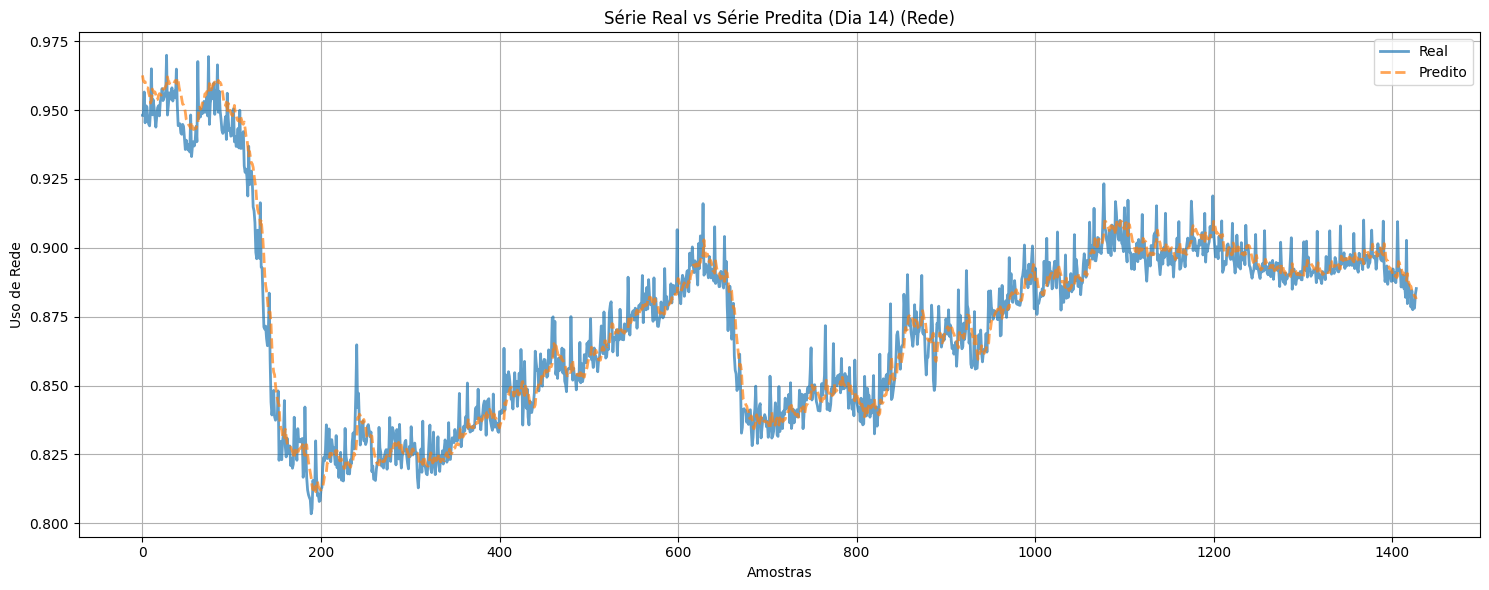

In [34]:
import matplotlib.pyplot as plt

os.makedirs("results", exist_ok=True)

# Plotar a série real e a série predita
plt.figure(figsize=(15, 6))
plt.plot(y_test[:len(y_test)], label="Real", linewidth=2, alpha=0.7)
plt.plot(y_pred[:len(y_pred)], label="Predito", linewidth=2, alpha=0.7, linestyle="--")
plt.title(f"Série Real vs Série Predita ({dias}) ({recurso})")
plt.xlabel("Amostras")
plt.ylabel(f"Uso de {recurso}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"results/{recurso}_prediction_vs_real_{dias.replace(' ', '_')}.png", dpi=300)  # Salvar o gráfico
plt.show()